<a href="https://colab.research.google.com/github/TheAcoff/Notebook-Alura/blob/main/Machine_Learning_Classif_Servicos_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Classificação de Serviços:
## Base de dados
A base de dados utilizada mostra algumas informações vindas de um site que vende seviços. Nele, o usuário pode colocar um preço ao serviço e em quantas horas ele espera para concluir o projeto do início.

In [ ]:
import pandas as pd

In [ ]:
uri = 'https://gist.githubusercontent.com/guilhermesilveira/1b7d5475863c15f484ac495bd70975cf/raw/16aff7a0aee67e7c100a2a48b676a2d2d142f646/projects.csv'
dados = pd.read_csv(uri)
dados.head()

,unfinished,expected_hours,price
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


Iremos renoemar as colunas para facilitar o trabalho

In [ ]:
mapa = {
    'unfinished':'nao_finalizado',
    'expected_hours':'horas_esperadas',
    'price':'preco'
}
dados = dados.rename(columns = mapa)
dados.head()

,nao_finalizado,horas_esperadas,preco
0,1,26,192
1,1,88,9015
2,1,89,2577
3,1,42,275
4,1,39,170


Observamos as seguintes colunas:
- `nao_finalizado`: Situação do projeto
- `horas_esperadas`: Quantidade de horas para finalizar o projeto
- `preco`: Preço final do projeto

Para facilitar o entendimento do modelo, criaremos uma coluna para a situação do projeto, invertendo o `nao_finalizado`.

In [ ]:
troca = {
    0:1,
    1:0
}

dados['finalizado'] = dados.nao_finalizado.map(troca)
dados.tail()

,nao_finalizado,horas_esperadas,preco,finalizado
2152,0,80,7518,1
2153,1,52,1332,0
2154,0,40,473,1
2155,0,75,5324,1
2156,1,37,377,0


Visualisando a relação entre horas, preço e se está finalizado, criamos o seguinte gráfico:

<Axes: xlabel='horas_esperadas', ylabel='preco'>

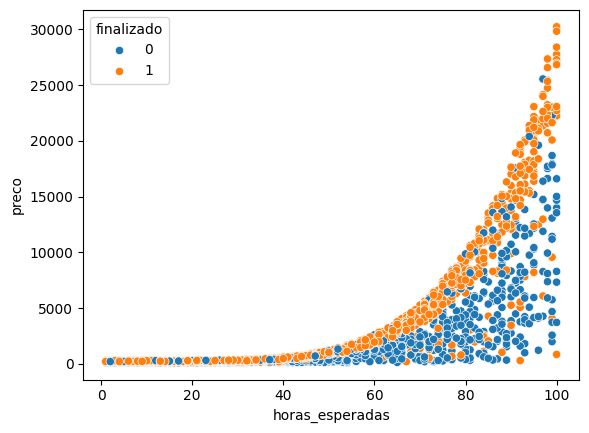

In [ ]:
import seaborn as sns

sns.scatterplot(data = dados, x = 'horas_esperadas', y = 'preco', hue = 'finalizado')

separando o finalizado do não finalizado,

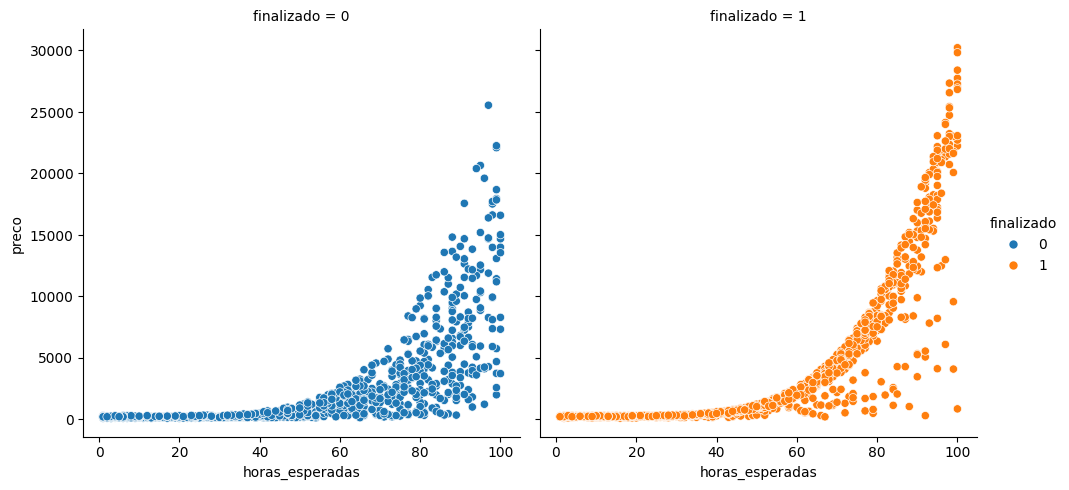

In [ ]:
sns.relplot(data = dados, x = 'horas_esperadas', y = 'preco', hue = 'finalizado', col = 'finalizado')

## Modelo Linear

Com essa visualização, podemos observar um certo padrão na distribuição dos dados. Com isso, tentaremos criar um modelo para prever futuras entradas.

Primeiramente, escolheremos um modelo linear para analisar o seu comportamento com esse tipo de distribuição de dados, mesmo sabendo que não é a forma mais correta de fazer isso.

In [ ]:
x = dados[['horas_esperadas','preco']]
y = dados['finalizado']

In [104]:
from sklearn.model_selection import train_test_split

#Definindo uma seed
SEED = 12
np.random.seed(SEED)

#Separando as amostras
x_treino, x_teste, y_treino, y_teste =  train_test_split(x, y,
                                                         test_size = 0.25,
                                                         stratify = y)

In [105]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#Implementação do modelo
modelo = LinearSVC()
modelo.fit(x_treino, y_treino)
previsoes = modelo.predict(x_teste)

#Teste de acurácia
accuracy = accuracy_score(y_teste, previsoes)
print(f'Treinamos com {len(x_treino)} dados, e testamos com {len(x_teste)}')
print(f'Acurácia: {accuracy*100:.2f} %')

Treinamos com 1617 dados, e testamos com 540
Acurácia: 57.04 %


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Observamos que o modelo tem uma acurácia baixa. Fazendo um teste de Dummy Classification manual, podemos ver se o modelo está prevendo apenas o valor mais frequente ou criando de fato uma relação.

In [106]:
import numpy as np
ones = np.ones(540)
acuracia = accuracy_score(y_teste, ones) *100
acuracia

52.59259259259259

Com isso, vemos que mesmo forçando uma previsão `ones` com apenas valores iguais a $1$, temos a taxa de acerto igual ao do modelo. Podemos visualizar esse comportamento de uma forma mais completa.

<Axes: xlabel='horas_esperadas', ylabel='preco'>

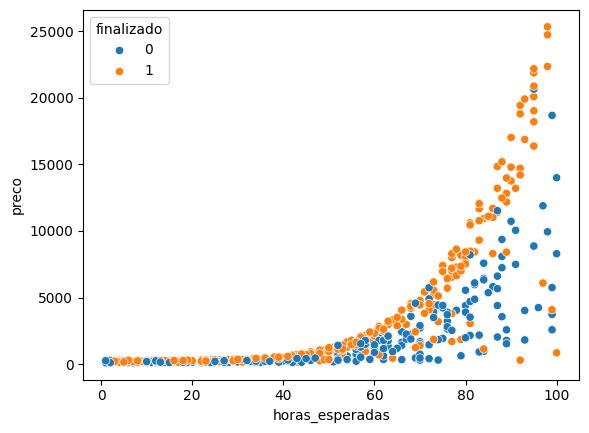

In [108]:
sns.scatterplot(data = x_teste, x='horas_esperadas', y = 'preco', hue = y_teste)

Outra análise que podemos fazer quando lidamos com bidimensionais é preencher com dados aleatórios e colorir toda a região do gráfico com as previsões.

Primeiramente, temos que saber o intervalo de dados.

In [109]:
x_min = x_teste.horas_esperadas.min()
x_max = x_teste.horas_esperadas.max()
y_min = x_teste.preco.min()
y_max = x_teste.preco.max()

print(x_min, x_max, y_min, y_max)

1 100 100 25332


depois, definimos um número de pontos da imagem, e normalizamos o intervalo dos eixos para saber a divisão exata com:
$$
eixo = \frac{x_{max}-x_{min}}{pixels}
$$

In [110]:
pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

In [111]:
xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

Com os pontos criados, rodamos no modelo para ver qual a escolha:

In [112]:
z = modelo.predict(pontos)
z = z.reshape(xx.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


Então, plotamos o gráfico

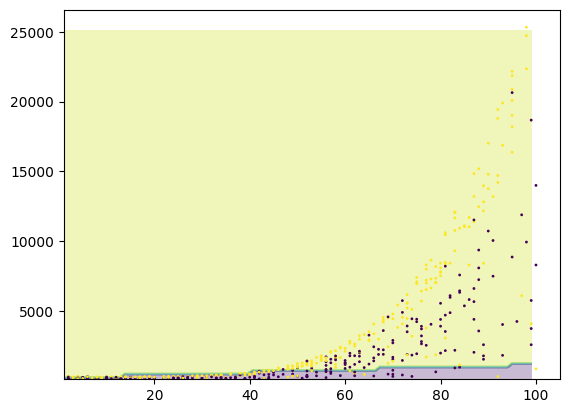

In [113]:
import matplotlib.pyplot as plt

plt.contourf(xx, yy, z, alpha = 0.3)
plt.scatter(x_teste.horas_esperadas, x_teste.preco, c = y_teste, s=1)

No gráfico, podemos ver a cruva de decisão *decision boundary*. Vemos que o nosso modelo classifica apenas linhas retas, ele tenta encontrar um relacionamento linear entre as grandezas. Porém, esse modelo de previsão não está correto.


## Modelo não linear
Podemos tentar outra abordagem, usando outro modelo


In [119]:
def plot_decisao(x_teste, modelo):
  x_min = x_teste.horas_esperadas.min()
  x_max = x_teste.horas_esperadas.max()
  y_min = x_teste.preco.min()
  y_max = x_teste.preco.max()

  pixels = 100
  eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
  eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

  xx, yy = np.meshgrid(eixo_x, eixo_y)
  pontos = np.c_[xx.ravel(), yy.ravel()]

  z = modelo.predict(pontos)
  z = z.reshape(xx.shape)

  plt.contourf(xx, yy, z, alpha = 0.3)
  plt.scatter(x_teste.horas_esperadas, x_teste.preco, c = y_teste, s=1)

Treinamos com 1617 dados, e testamos com 540
Acurácia: 58.89 %


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


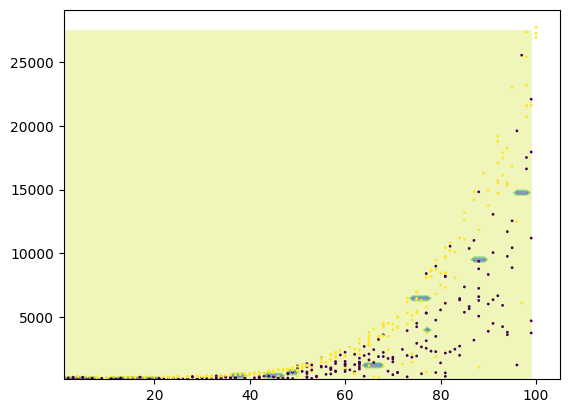

In [132]:
from sklearn.svm import SVC

SEED = 20
np.random.seed(SEED)

x_treino, x_teste, y_treino, y_teste =  train_test_split(x, y,
                                                         test_size = 0.25,
                                                         stratify = y)

modelo = SVC(gamma = 'auto')
modelo.fit(x_treino, y_treino)
previsoes = modelo.predict(x_teste)

accuracy = accuracy_score(y_teste, previsoes)
print(f'Treinamos com {len(x_treino)} dados, e testamos com {len(x_teste)}')
print(f'Acurácia: {accuracy*100:.2f} %')

plot_decisao(x_teste, modelo)

Temos agora a criação de pequenas regiões para tentar prever o comportamento, mas ainda não é o que queremos.

Para facilitar o aprendizado, podemos deixar os dados em uma escala específica, utilizando scalers.

In [134]:
from sklearn.preprocessing import StandardScaler

SEED = 20
np.random.seed(SEED)

x_treino_raw, x_teste_raw, y_treino, y_teste =  train_test_split(x, y,
                                                         test_size = 0.25,
                                                         stratify = y)

#Implementação do Scaler
scaler = StandardScaler()
scaler.fit(x_treino_raw)
x_treino = scaler.transform(x_treino_raw)
x_teste = scaler.transform(x_teste_raw)

modelo = SVC(gamma='auto')
modelo.fit(x_treino, y_treino)
previsoes = modelo.predict(x_teste)

accuracy = accuracy_score(y_teste, previsoes)
print(f'Treinamos com {len(x_treino)} dados, e testamos com {len(x_teste)}')
print(f'Acurácia: {accuracy*100:.2f} %')

Treinamos com 1617 dados, e testamos com 540
Acurácia: 70.37 %


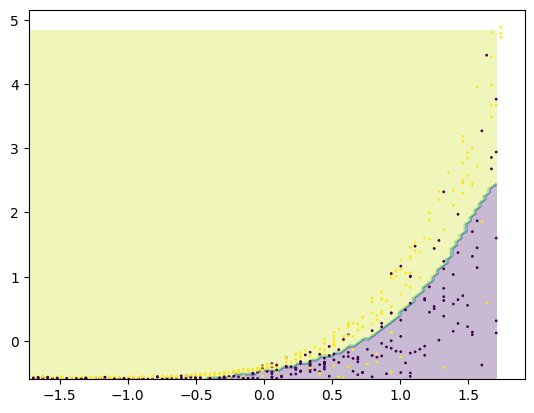

In [135]:
data_x = x_teste[:,0]
data_y = x_teste[:,1]

x_min = data_x.min()
x_max = data_x.max()
y_min = data_y.min()
y_max = data_y.max()

pixels = 100
eixo_x = np.arange(x_min, x_max, (x_max - x_min) / pixels)
eixo_y = np.arange(y_min, y_max, (y_max - y_min) / pixels)

xx, yy = np.meshgrid(eixo_x, eixo_y)
pontos = np.c_[xx.ravel(), yy.ravel()]

z = modelo.predict(pontos)
z = z.reshape(xx.shape)

plt.contourf(xx, yy, z, alpha = 0.3)
plt.scatter(data_x, data_y, c = y_teste, s=1)


Está bem melhor, o modelo conseguiu observar que em uma região específica tem uma tendência dos projetos estarem finalizados.